#  Multivariate Analysis for the Muon g-2 calorimeter calibration

# 1. Python libraries

The following libraries are used here:

pandas: The Python Data Analysis Library is used for storing the data in dataframes and manipulation.
numpy: Python scientific computing library.
matplotlib: Python plotting library.
seaborn: Statistical data visualization based on matplotlib.
scikit-learn: Sklearn is a machine learning library for Python.
scipy.stats: Provides a number of probability distributions and statistical functions.

The libraries versions are:

In [1]:
from __future__ import print_function, division  # for compatibility with python 3.x
import warnings
warnings.filterwarnings('ignore')  # don't print out warnings

%load_ext watermark
%watermark -v -m -p pandas,numpy,matplotlib,seaborn,sklearn,scipy -g

CPython 3.6.1
IPython 6.0.0

pandas 0.20.1
numpy 1.12.1
matplotlib 2.0.2
seaborn 0.7.1
sklearn 0.18.1
scipy 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.38)
system     : Darwin
release    : 16.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   :


## 1.1 Importing the libraries

In [2]:
from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML

# figures inline in notebook
%matplotlib inline

np.set_printoptions(suppress=True)

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

In [3]:
#%qtconsole

# 2. Get started

## 2.1 Reading Multivariate Analysis Data into Python

The first thing that you will want to do to analyse your multivariate data will be to read it into Python, and to plot the data. For data analysis an I will be using the Python Data Analysis Library (pandas, imported as pd), which provides a number of useful functions for reading and analyzing the data, as well as a DataFrame storage structure, similar to that found in other popular data analytics languages, such as R.



There is one row per calorimeter channel. The first column contains the crystal number in a calorimeter (labelled 0, 1, 2, ... to 53), and the following nine columns contain the variables like calibration constants c1, c2, c and so on. The columns are separated by commas, i.e. it is a comma-separated (csv) file without a header row.

The data can be read in a pandas dataframe using the read_csv() function. The argument header=None tells the function that there is no header in the beginning of the file.

In [4]:
data = pd.read_csv("calibration.csv", header=None)

# rename column names to be similar to R naming convention
#data.columns = ["V"+str(i) for i in range(1, len(data.columns)+1)] 
data.columns = ["xtalNum", "colNum", "c1", "c2", "c", "laserIntensity", "pgaGain", "bkBias", "temperature", "lightTrans"]
data.xtalNum = data.xtalNum.astype(str)
X = data.loc[:, "c1":]  # independent variables data
y = data.xtalNum  # dependent variable data
data

,xtalNum,colNum,c1,c2,c,laserIntensity,pgaGain,bkBias,temperature,lightTrans
0,0,0,0.248495,1.12970,0.280725,1745.82,3.34965,68.3,31.57,174.970
1,1,1,0.239881,1.15233,0.276422,1547.47,5.01187,67.9,32.44,159.965
2,2,2,0.231150,1.15393,0.266731,1379.89,5.30884,67.9,33.31,175.705
3,3,3,0.247449,1.26610,0.313294,1782.03,2.51189,67.6,34.12,157.860
4,4,4,0.243999,1.19637,0.291914,1323.10,4.46684,67.6,36.00,160.615
5,5,5,0.205105,1.16731,0.239422,1263.01,2.73842,67.9,37.56,170.500
6,6,6,0.231958,1.10825,0.257067,1341.31,1.99526,67.9,36.94,168.160
7,7,7,0.240552,1.18684,0.285496,1334.00,5.01187,68.3,38.25,170.032
8,8,8,0.236362,1.13659,0.268646,1354.10,4.59727,68.3,37.88,168.485
9,9,0,0.225452,1.04880,0.236455,1541.82,3.65174,67.6,31.93,156.905


## 2.2 Plotting Multivariate Data

Once you have read a multivariate data set into python, the next step is usually to make a plot of the data.

### a) A Matrix Scatterplot

One common way of plotting multivariate data is to make a matrix scatterplot, showing each pair of variables plotted against each other. We can use the scatter_matrix() function from the pandas.tools.plotting package to do this.

To use the scatter_matrix() function, you need to give it as its input the variables that you want included in the plot. Here we include all the variables from c1 to light transmission. The parameter diagonal allows us to specify whether to plot a histogram ("hist") or a Kernel Density Estimation ("kde") for the variable. We can extract just these columns from the variable data by typing:

In [32]:
data.loc[:, "c1":"lightTrans"]

,c1,c2,c,laserIntensity,pgaGain,bkBias,temperature,lightTrans
0,0.248495,1.12970,0.280725,1745.82,3.34965,68.3,31.57,174.970
1,0.239881,1.15233,0.276422,1547.47,5.01187,67.9,32.44,159.965
2,0.231150,1.15393,0.266731,1379.89,5.30884,67.9,33.31,175.705
3,0.247449,1.26610,0.313294,1782.03,2.51189,67.6,34.12,157.860
4,0.243999,1.19637,0.291914,1323.10,4.46684,67.6,36.00,160.615
5,0.205105,1.16731,0.239422,1263.01,2.73842,67.9,37.56,170.500
6,0.231958,1.10825,0.257067,1341.31,1.99526,67.9,36.94,168.160
7,0.240552,1.18684,0.285496,1334.00,5.01187,68.3,38.25,170.032
8,0.236362,1.13659,0.268646,1354.10,4.59727,68.3,37.88,168.485
9,0.225452,1.04880,0.236455,1541.82,3.65174,67.6,31.93,156.905


To make a matrix scatterplot of just these 5 variables using the scatter_matrix() function we type:

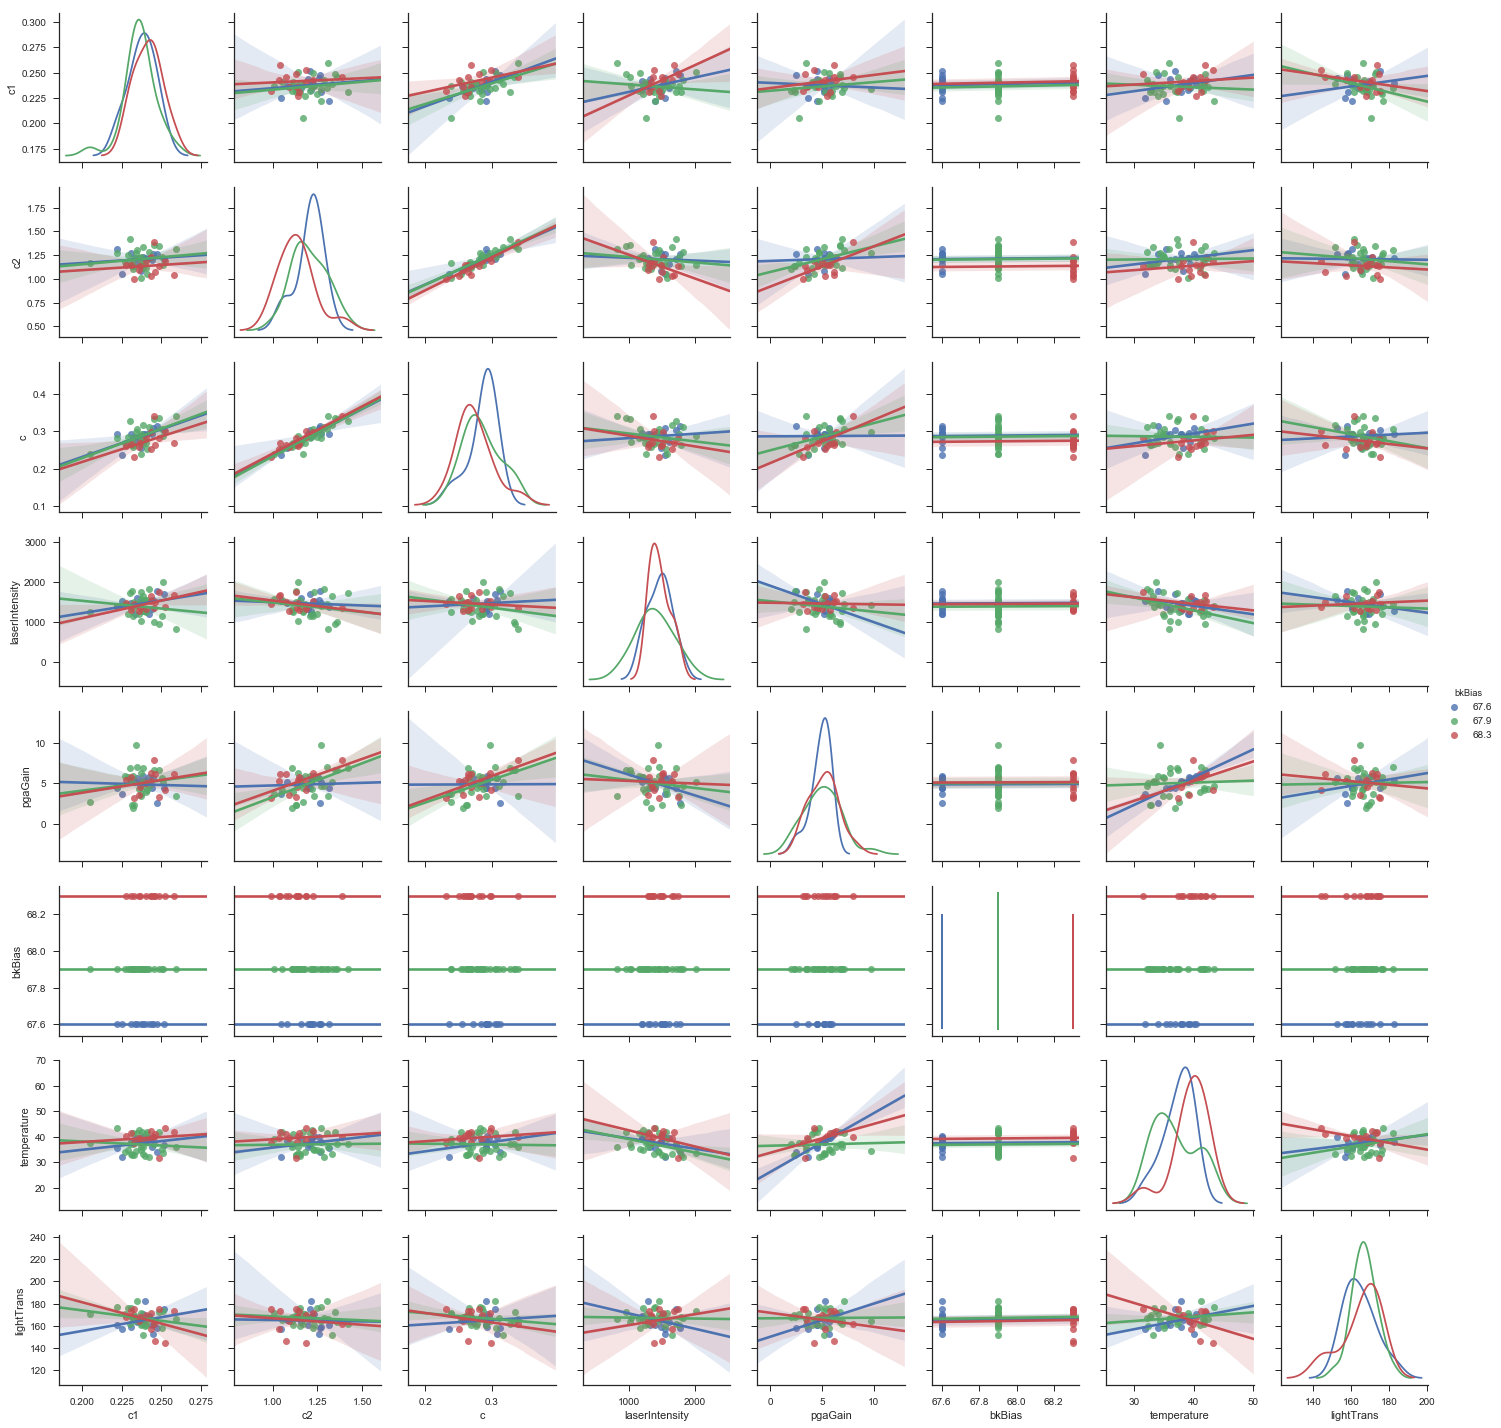

In [6]:
#pd.plotting.scatter_matrix(data.loc[:, "V2":"V9"], diagonal="kde", figsize=(12, 10), s=100, alpha=0.6)
#plt.tight_layout()
#plt.show()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data.loc[:, "c1":"lightTrans"], kind="reg", diag_kind="kde", hue="bkBias")

In this matrix scatterplot, the diagonal cells show histograms of each of the variables, in this case the values of the variables (variables c1, c2, ...., light transmission). Each of the off-diagonal cells is a scatterplot of two of the five variables, for example, the second cell in the first row is a scatterplot of c2 (y-axis) against c (x-axis).

### b) A Scatterplot with the Data Points Labelled by their Group

If you see an interesting scatterplot for two variables in the matrix scatterplot, you may want to plot that scatterplot in more detail, with the data points labelled by their group (their bkBiases in this case).

For example, in the matrix scatterplot above, the cell in the fifth column of the second row down is a scatterplot of pgaGain (x-axis) against c2 (y-axis). If you look at this scatterplot, it appears that there may be a positive relationship between pgaGain and c2.

We may therefore decide to examine the relationship between pgaGain and c2 more closely, by plotting a scatterplot of these two variables, with the data points labelled by their group (their cultivar). To plot a scatterplot of two variables, we can use the lmplot function from the seaborn package. The c2 and pgaGain variables are stored in the columns c2 and pgaGain of the variable data. The first two parameters in the lmplot() function are the columns to be plotted against each other in x-y, the third parameter specifies the data, the hue parameter is the column name used for the labels of the datapoints, i.e. the classes they belong to, lastly, the fit_reg parameter is set to False when we do not want to plot a regression model relating to the x-y variables. Therefore, to plot the scatterplot, we type:

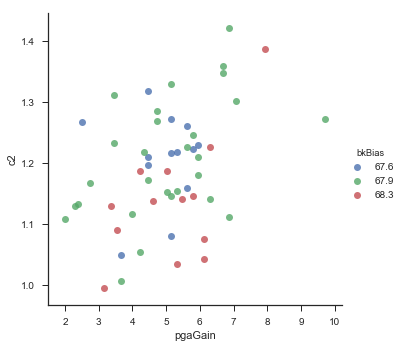

In [34]:
sns.lmplot("pgaGain","c2", data,hue="bkBias", fit_reg=False);

### c) A Profile Plot

Another type of plot that is useful is a profile plot, which shows the variation in each of the variables, by plotting the value of each of the variables for each of the samples.

This can be achieved using pandas plot facilities, which are built upon matplotlib, by running the following:

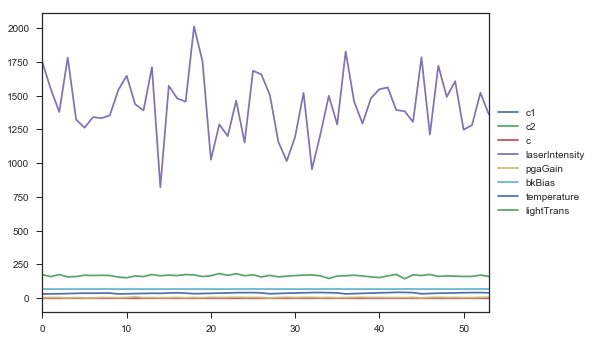

In [8]:
ax = data[["xtalNum", "c1", "c2", "c", "laserIntensity", "pgaGain", "bkBias", "temperature", "lightTrans"]].plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## 2.3 Calculating Summary Statistics for Multivariate Data

Another thing that you are likely to want to do is to calculate summary statistics such as the mean and standard deviation for each of the variables in your multivariate data set.

This is easy to do, using the mean() and std() functions in numpy and applying them to the dataframe using its member function apply.

Pandas allows to do simple operations directly calling them as methods, for example we could do compute the means of a dataframe `df` by calling `df.mean()`.
An alternative option is to use the apply method of the pandas.DataFrame class, which applies the passed argument function along the input axis of the DataFrame. This method is powerful as it allows passing any function we want to be applied in our data.

For example, say we want to calculate the mean and standard deviations of each of the variables in this analysis. These are stored in columns c1 to lightTrans of the variable data, which has been previously assigned to X for convenience. So we type:

In [9]:
X.apply(np.mean)

c1                   0.238049
c2                   1.189972
c                    0.283323
laserIntensity    1429.963556
pgaGain              5.016922
bkBias              67.924074
temperature         37.695556
lightTrans         166.151981
dtype: float64

In [10]:
X.apply(np.std)

c1                  0.009371
c2                  0.096044
c                   0.026121
laserIntensity    232.237621
pgaGain             1.463421
bkBias              0.244143
temperature         3.308397
lightTrans          7.814838
dtype: float64

## Calculating Correlations for Multivariate Data

If we calculate the correlation between variable c1 and c2, we get

In [39]:
corr = stats.pearsonr(X.c2, X.c1)
print("p-value:\t", corr[1])
print("cor:\t\t", corr[0])

p-value:	 0.681885133402
cor:		 0.0570690955177


This tells us that the correlation coefficient is about 0.057, which is a very weak correlation. Furthermore, the p-value for the statistical test of whether the correlation coefficient is significantly different from zero is 0.68. This is much greater than 0.05 (which we can use here as a cutoff for statistical significance), so there is very weak evidence that that the correlation is non-zero.

If you have a lot of variables, you can use the pandas.DataFrame method corr() to calculate a correlation matrix that shows the correlation coefficient for each pair of variables.

In [12]:
corrmat = X.corr()
corrmat

,c1,c2,c,laserIntensity,pgaGain,bkBias,temperature,lightTrans
c1,1.000000,0.057069,0.479496,0.053079,0.134602,0.157776,0.076098,-0.182451
c2,0.057069,1.000000,0.902861,-0.196505,0.403263,-0.273855,-0.025743,-0.066205
c,0.479496,0.902861,1.000000,-0.162033,0.404128,-0.175030,0.004397,-0.136611
laserIntensity,0.053079,-0.196505,-0.162033,1.000000,-0.175257,0.014951,-0.315124,-0.067922
pgaGain,0.134602,0.403263,0.404128,-0.175257,1.000000,0.065337,0.241526,0.016795
bkBias,0.157776,-0.273855,-0.175030,0.014951,0.065337,1.000000,0.242653,0.007796
temperature,0.076098,-0.025743,0.004397,-0.315124,0.241526,0.242653,1.000000,0.006847
lightTrans,-0.182451,-0.066205,-0.136611,-0.067922,0.016795,0.007796,0.006847,1.000000


A better graphical representation of the correlation matrix is via a correlation matrix plot in the form of a heatmap.

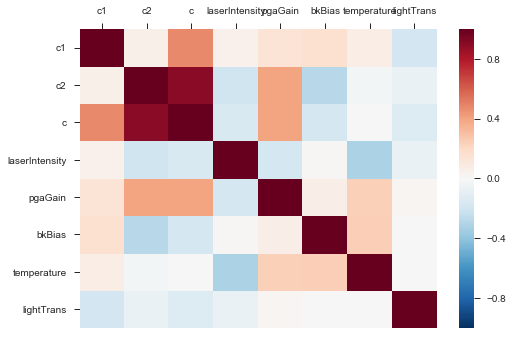

In [13]:
sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

Or an alternative nice visualization is via a Hinton diagram. The color of the boxes determines the sign of the correlation, in this case red for positive and blue for negative correlations; while the size of the boxes determines their magnitude, the bigger the box the higher the magnitude.

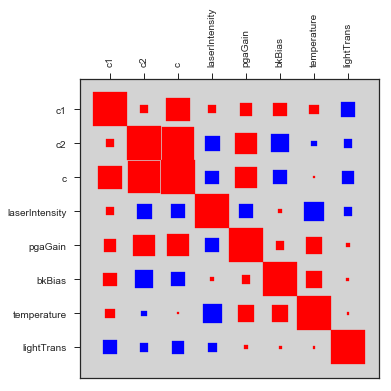

In [14]:
# adapted from http://matplotlib.org/examples/specialty_plots/hinton_demo.html
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)

    ax.autoscale_view()
    ax.invert_yaxis()

hinton(corrmat)

Although the correlation matrix and diagrams are useful for quickly looking to identify the strongest correlations, they still require labor work to find the top N strongest correlations. For this you can use the function mosthighlycorrelated() below.

The function mosthighlycorrelated() will print out the linear correlation coefficients for each pair of variables in your data set, in order of the correlation coefficient. This lets you see very easily which pair of variables are most highly correlated.

In [15]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

The arguments of the function are the variables that you want to calculate the correlations for, and the number of top correlation coefficients to print out (for example, you can tell it to print out the largest 10 correlation coefficients, or the largest 20).

For example, to calculate correlation coefficients between the concentrations of the 13 chemicals in the wine samples, and to print out the top 10 pairwise correlation coefficients, you can type:

In [16]:
mosthighlycorrelated(X, 10)

,FirstVariable,SecondVariable,Correlation
0,c2,c,0.902861
1,c1,c,0.479496
2,c,pgaGain,0.404128
3,c2,pgaGain,0.403263
4,laserIntensity,temperature,-0.315124
5,c2,bkBias,-0.273855
6,bkBias,temperature,0.242653
7,pgaGain,temperature,0.241526
8,c2,laserIntensity,-0.196505
9,c1,lightTrans,-0.182451


This tells us that the pair of variables with the highest linear correlation coefficient are V3 and V4 (correlation = 0.90 approximately).